In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from DQNAgent import DeepQNetwork, experience_buffer

# some useful functions
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars/2]):
        op_holder.append(tfVars[idx+total_vars/2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars/2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)
        
def processState(states, shape):
    return np.reshape(states, shape)

In [2]:
# train parameters
batch_size = 32 #How many experiences to use for each training step.
update_freq = 1 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 10000 #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.

pre_train_steps = 100  #How many steps of random actions before training begins.
load_model = False #Whether to load a saved model.
tau = 0.1 #Rate to update target network toward primary network
# sizes
ob_size = 4
action_size = 2

In [3]:
env = gym.make('CartPole-v1')
env.reset()
env.render()

tf.reset_default_graph()

# double Q networks
mainQN = DeepQNetwork(ob_size, action_size)
targetQN = DeepQNetwork(ob_size, action_size)

init = tf.initialize_all_variables()
saver = tf.train.Saver(max_to_keep = 100)
trainables = tf.trainable_variables()
#
targetOps = updateTargetGraph(trainables, tau)
copyOps = updateTargetGraph(trainables, 1.0)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
QList = []
total_steps = 0

ShowInterval = 2
num_maxsteps = 500

[2017-07-07 16:08:53,398] Making new env: CartPole-v1


In [4]:
sess = tf.Session()
sess.run(init)
for episode in range(num_episodes):
    episodeBuffer = experience_buffer()
    # reset environment and get first observation
    env.reset()
    action = env.action_space.sample()
    s, r, d, info = env.step(action)
    sum_step = 0
    
    for simstep in range(num_maxsteps):
        # generate action
        if np.random.rand(1) < e or total_steps < pre_train_steps:
            a = np.random.randint(0, 2)
        else:
            a = sess.run(mainQN.predict,feed_dict={mainQN.ob_input:[s]})[0]
        # record Q-values
        Q = sess.run(mainQN.Qout, feed_dict={mainQN.ob_input:[s]})[0]
        
        # perform action
        s1, r, d, info = env.step(a)

        # show 
        if simstep % ShowInterval == 0:
            #sim.draw([total_steps])
            pass

        total_steps += 1
        # save to experience buffer
        episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5]))

        if total_steps > pre_train_steps:
            if e > endE:
                e -= stepDrop
            if total_steps % (update_freq) == 0:
                # get random batch of experience
                trainBatch = myBuffer.sample(batch_size)
                # Perform the Double-DQN update to the target Q-values
                Q1 = sess.run(mainQN.predict,feed_dict={mainQN.ob_input:np.vstack(trainBatch[:,3])})
                Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.ob_input:np.vstack(trainBatch[:,3])})
                end_multiplier = -(trainBatch[:,4] - 1)
                doubleQ = Q2[range(batch_size),Q1]
                targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                # update the network with our target values
                _ = sess.run(mainQN.updateModel, feed_dict={ mainQN.ob_input:np.vstack(trainBatch[:,0]),
                                                             mainQN.targetQ:targetQ, 
                                                             mainQN.actions:trainBatch[:,1]})
                # update the target network in the direction of the primary network
                updateTarget(targetOps, sess)
        s = s1
        sum_step = sum_step + simstep
        if d:
            #print simstep
            break
            
    if episode % 100 == 0:
        print("EP:", episode, 'T:', total_steps, 'ES:', sum_step/100.0, e)
    # END of one episode    

    # get all experience from this episode and discount their rewards
    myBuffer.add(episodeBuffer.buffer)
    jList.append(simstep)
# END of all episode


('EP:', 0, 'T:', 34, 'ES:', 5.61, 1)
('EP:', 100, 'T:', 2711, 'ES:', 0.66, 0.7650099999999099)
('EP:', 200, 'T:', 20094, 'ES:', 291.61, 0.09999999999985551)
('EP:', 300, 'T:', 44561, 'ES:', 215.28, 0.09999999999985551)
('EP:', 400, 'T:', 67342, 'ES:', 277.3, 0.09999999999985551)
('EP:', 500, 'T:', 87687, 'ES:', 1102.15, 0.09999999999985551)
('EP:', 600, 'T:', 125065, 'ES:', 154.0, 0.09999999999985551)


KeyboardInterrupt: 

In [10]:
# render and test
actionlog = []
for episode in range(10):
    env.reset()
    a = env.action_space.sample()
    s, r, d, info = env.step(a)
    for step in range(1000):
        a = sess.run(mainQN.predict,feed_dict={mainQN.ob_input:[s]})[0]
        s, r, d, info = env.step(a)
        actionlog.append(a)
        env.render()
        if d:
            break
    print step


161
168
163
164
159


KeyboardInterrupt: 

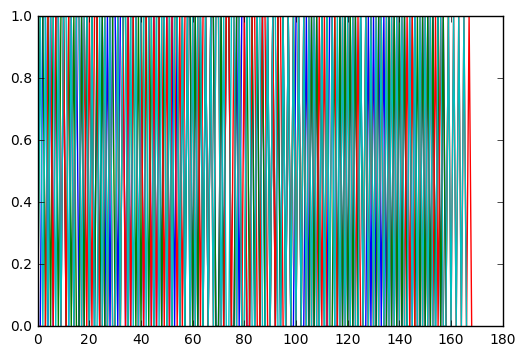

In [9]:
plt.show()